# Analiza projektów kickstarter

## Przygotowanie bibliotek wykorzystywanych w systemie

W systemie wykorzystywane są następujące biblioteki

- **pandas** - odczyt, zapis i operacje na danych
- **datetime** - operacje na datach
- **sklearn** - funkcje wykorzystywane w analizie danych
- **math**, **numpy** - liczne funkcje matematyczne
- **seaborn** - graficzna reprezentacja danych
- **random** - generowanie liczb losowych
- **matplotlib** - wykresy

In [2]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import math
import numpy as np
import seaborn as sns
import random as rand
import matplotlib.pyplot as plt

## Konfiguracja systemu

Ta sekcja zawiera ustawienia dla poszczególnych bibliotek. Są to konfiguracje sposobu wyświetlania danych dla DataFrame oraz kodowania przy

In [3]:
# Skonfigurowanie opcji wyświetlania
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

default_figsize = (13, 9)
plt.rcParams["figure.figsize"] = default_figsize

# Parametry wykorzystywane przy wczytywaniu danych
encoding='ISO-8859-1'

## Przygotowanie danych

### Wczytanie danych

In [4]:
dataset_path = './data/kickstarter-projects-filtered.csv'
rows_number = 1000
all_csv_columns = ['main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country']
df = pd.read_csv(
    dataset_path,
    encoding=encoding,
    low_memory=False
    ).head(rows_number).filter(all_csv_columns, axis=1)

print(df.head())

  main_category currency        deadline     goal        launched  pledged       state  backers country
0    Publishing      GBP  09-10-15 11:36   1000.0  11-08-15 12:12      0.0      failed        0      GB
1  Film & Video      USD   26-02-13 0:20  45000.0   12-01-13 0:20    220.0      failed        3      US
2         Music      USD   16-04-12 4:24   5000.0   17-03-12 3:24      1.0      failed        1      US
3          Food      USD  01-04-16 13:38  50000.0  26-02-16 13:38  52375.0  successful      224      US
4          Food      USD  21-12-14 18:30   1000.0  01-12-14 18:30   1205.0  successful       16      US


### Konwersja danych tekstowych na dane liczbowe

Aby dane mogły zostać poprawnie przetworzone w dalszych krokach przy użyciu metody PCA, dane tekstowe należy zamienić na dane liczbowe. Do tego celu można wykorzystać słowniki. Algorytm konwersji jest następujący:
- zebrać wszystkie wartości występujące w danej kolumnie
- przyporządkować każdej wartości kolejną liczbę naturalną rozpoczynając od zera (lub jedynki).

In [5]:
def get_all_values_from_column(df, col_name):
    values = []
    for i in range(0, len(df[col_name])):
        category = df[col_name][i]
        if category not in values:
            values.append(category)

    return values


def create_label_number_dict(names, start_from_zero = True):
    normalized = {}
    zero_margin = 1 - int(start_from_zero)
    for i in range(0, len(names)):
        name = names[i]
        normalized[name] = i + zero_margin

    return normalized

def map_text_to_number(df, column_name, dict):
    mapped = pd.Series(df[column_name].map(dict), name=column_name)
    df.update(mapped)

    return df

In [6]:
categories = get_all_values_from_column(df, 'main_category')
countries = get_all_values_from_column(df, 'country')
states = get_all_values_from_column(df, 'state')
currencies = get_all_values_from_column(df, 'currency')

categories_dict = create_label_number_dict(categories)
countries_dict = create_label_number_dict(countries)
states_dict = create_label_number_dict(states)
currencies_dict = create_label_number_dict(currencies)

df = map_text_to_number(df, 'main_category', categories_dict)
df = map_text_to_number(df, 'country', countries_dict)
df = map_text_to_number(df, 'state', states_dict)
df = map_text_to_number(df, 'currency', currencies_dict)

### Konwersja dat na dane liczbowe

W przypadku dat przyjęto strategię reprezentacji ich jako roku

In [7]:
def date_to_timestamp(dt):
    return datetime.strptime(dt, "%d-%m-%y %H:%M").year


def map_date_to_timestamp(df, column_names):
    for column_name in column_names:
        mapped = pd.Series(df[column_name].map(date_to_timestamp), name=column_name)
        df.update(mapped)

    return df

df = map_date_to_timestamp(df, ['launched', 'deadline'])

### Dodanie sztucznej kolumny _pledged_ratio_

Kolumna przedstawia stosunek zebranej kwoty do postawionego celu w postaci procentowej.

In [8]:
df['pledged_ratio'] = df['pledged'].astype(float) / df['goal'].astype(float) * 100
df.head()

,main_category,currency,deadline,goal,launched,pledged,state,backers,country,pledged_ratio
0,0,0,2015,1000.0,2015,0.0,0,0,0,0.000000
1,1,1,2013,45000.0,2013,220.0,0,3,1,0.488889
2,2,1,2012,5000.0,2012,1.0,0,1,1,0.020000
3,3,1,2016,50000.0,2016,52375.0,1,224,1,104.750000
4,3,1,2014,1000.0,2014,1205.0,1,16,1,120.500000


### Normalizowanie danych

Na tym etapie zakresy danych są bardzo zróżnicowane. Aby ułatwić analizę, dane należy znormalizować, tzn sprowadzić je do wspólnego, w miarę zbliżonego zakresu

In [9]:
columns_to_normalize = ['main_category','currency', 'country', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'pledged_ratio']
df[columns_to_normalize] = df[columns_to_normalize].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df.head()

,main_category,currency,deadline,goal,launched,pledged,state,backers,country,pledged_ratio
0,0.0,0.0,0.857143,0.000333,0.857143,0.000000,0.0,0.000000,0.0,0.000000e+00
1,0.071429,0.111111,0.571429,0.015000,0.571429,0.000261,0.0,0.000359,0.058824,8.637613e-06
2,0.142857,0.111111,0.428571,0.001666,0.428571,0.000001,0.0,0.000120,0.058824,3.533569e-07
3,0.214286,0.111111,1.0,0.016666,1.0,0.062075,1.0,0.026823,0.058824,1.850707e-03
4,0.214286,0.111111,0.714286,0.000333,0.714286,0.001428,1.0,0.001916,0.058824,2.128975e-03


Dla poprawności dalszych kroków można sprawdzić, czy któreś kolumny nie zawierają niepoprawnych/pustych danych

In [10]:
is_any_nan = False
for column in all_csv_columns:
    is_any_nan = is_any_nan or df[column].isnull().values.any()

print(f'\nCzy istnieją nieprawidłowe wartości w zbiorze danych: {is_any_nan}\n')


Czy istnieją nieprawidłowe wartości w zbiorze danych: False



## Podział zbioru na dane uczące i dane testowe

Do stworzenia systemu potrzebne są zarówno dane uczące --- te, z których algorytmy będą czerpały informacje o zależnościach, jak i dane testowe, wykorzystywane do sprawdzenia poprawności zaimplementowanych algorytmów. Podziału dokonano w stosunku 90/10

In [11]:
train_to_test_ratio = 0.1
df_train, df_test = train_test_split(df, test_size=train_to_test_ratio)

## Analiza PCA

### Wybór ilości kolumn

Analiza PCA pozwala oszacować jaką skuteczność będzie miał system dla danej ilości kolumn. Takie oszacowanie może być bardzo pomocne w wyborze optymalnej ilości kolumn. Jeżeli na podstawie posiadanych danych jesteśmy w stanie stworzyć system, który będzie cechował się skutecznością na poziomie 90% już dla 3 kolumn, to być może jest to wartość wystarczająca, zakładając, że na przykład dla 8 kolumn system będzie miał 93% skuteczności. Wtedy należy rozważyć, czy dodatkowa złożoność wynikająca z uwzględnienia większej ilości kolumn jest warta uzyskania dodatkowych 3 punktów procentowych skuteczności.

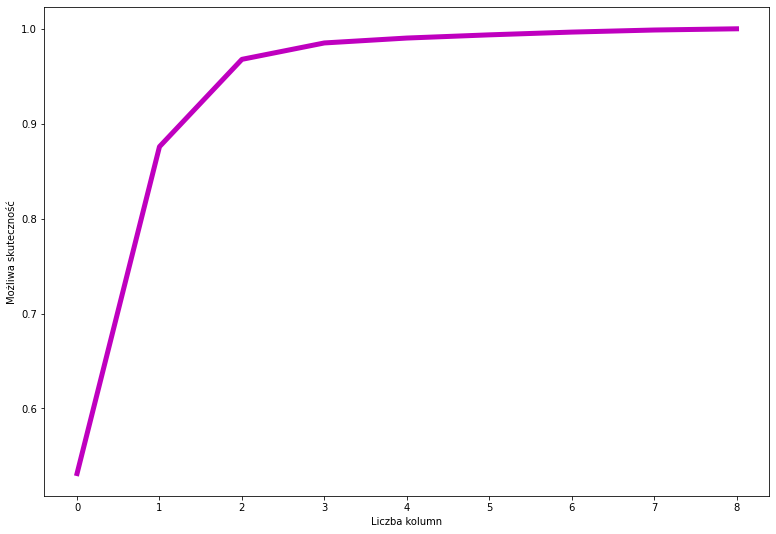

In [12]:
all_columns = [
    'currency',
    'country',
    'pledged_ratio',
    'state',
    'pledged',
    'backers',
    'goal',
    'main_category',
    'launched',
    'deadline',
]

all_features_columns = [
    'currency',
    'country',
    'pledged_ratio',
    'pledged',
    'backers',
    'goal',
    'main_category',
    'launched',
    'deadline',
]

labels_columns = ['state']

features = df_train[all_features_columns]
labels = df_train[labels_columns]

pca = PCA().fit(features, labels)
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'm', linewidth=5.0,)
plt.xlabel('Liczba kolumn')
plt.ylabel('Możliwa skuteczność')
plt.show()

Na powyższym wykresie można zauważyć, że już dla 3 kolumn można osiągnąć maksymalną skuteczność, więc analizowanie większej ilości kolumn nie jest potrzebne. Co więcej, mogłoby to wprowadzić dodatkowy poziom złożoności i niepotrzebną konieczność wykonywania obliczeń i analiz.

### Wybór kolumn do dalszej analizy

W celu wybrania kolumn mających największy wpływ na przynależność do klasy można posłużyć się macierzą kowariancji. Na jej podstawie możliwe będzie stworzenie mapy ciepła, która w przejrzysty sposób zobrazuje zależności między poszczególnymi kolumnami

#### Stworzenie macierzy kowariancji i wygenerowanie heatmapy

0: currency
1: country
2: pledged_ratio
3: state
4: pledged
5: backers
6: goal
7: main_category
8: launched
9: deadline


<AxesSubplot:>

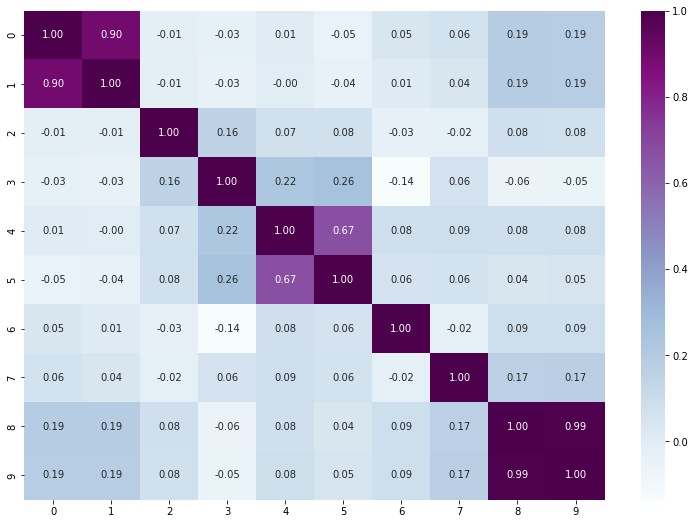

In [30]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_train[all_columns])

covariance_matrix = np.cov(features_scaled.T)

columns_dict = create_label_number_dict(all_columns, True)
for column in all_columns:
    print(f'{columns_dict[column]}: {column}')

fig, ax = plt.subplots(figsize=default_figsize)         # Sample figsize in inches
sns.heatmap(covariance_matrix, annot=True, ax=ax, fmt='0.2f', cmap='BuPu')

Kolumną decyzyjną jest kolumna numer 3 - jest to kolumna mówiąca o tym, czy projekt zakończył się porażką (1) czy sukcesem (2). Z mapy ciepła wynika korelacja następujących 3 kolumn z kolumną decyzyjną:

|  Kolumna 1  |  Kolumna 2  |  Kolumna 3   |
|:-----------:|:-----------:|:------------:|
| pledged (4) | backers (5) | launched (8) |

Na mapie widać inne mocne korelacje, np.:
  - 8 i 9 (_launched_ i _deadline_) - kolumny traktujące o dacie rozpoczęcia i zakończenia zbiórki,
  - 1 i 2 (_currency_ i _country_) - waluta i kraj
  - 4 i 5 (_pledged_ i _backers_) - zebrana kwota i ilość wspierających

Powyższe korelacje, mimo że są wysokie, nie wnoszą nic do analizowanego przykładu.

In [14]:
selected_features = ['pledged', 'backers', 'launched']

#### Uzasadnienie wyboru kolumn

Patrząc na charakterystykę wybranych kolumn, można stwierdzić następujące zależności:
  1. Kolumna **pledged** - ilość zgromadzonych środków
  2. Kolumna **backers** - ilość osób wspierających
  3. Kolumna **launched** - rok rozpoczęcia zbiórki

Pierwsze 2 kolumny mają oczywisty wpływ na powodzenie projektu, ponieważ im więcej środków zostanie zebranych, tym większa szansa na jego powodzenie. Na ilość środków wpływa z kolei ilość osób wspierających, ponieważ z reguły większa grupa osób jest w stanie zebrać więcej środków niż mniejsza grupa.

Wobec tego do dalszej analizy będziemy używać tylko wybranych kolumn.

## KNN

### Model pojedynczego elementu

In [15]:
class Startup:
    def __init__(self, dataframe_row):
        self.pledged = dataframe_row['pledged']
        self.backers = dataframe_row['backers']
        self.pledged_ratio = dataframe_row['pledged_ratio']
        self.state = dataframe_row['state']

    def get_distance_from(self, startup):
        return math.sqrt(
            math.pow(self.pledged - startup.pledged, 2)
            + math.pow(self.backers - startup.backers, 2)
            + math.pow(self.pledged_ratio - startup.pledged_ratio, 2)
        )

    def to_string(self):
        return f'pledged: {self.pledged}, backers: {self.backers}, pledged_ratio: {self.pledged_ratio}, state: {self.state}'

### Model klasy bazowej

In [16]:
class KnnBase:
    def __init__(self, df):
        self.df = df
        self.count = df['state'].count()
        self.items_objects = self.create_startups_objects(df)

    def create_startups_objects(self, df, clear_state=False):
        count = df['state'].count()
        objects = []
        for i in range(0, count):
            obj = Startup(df.iloc[i])
            if clear_state:
                obj.state = None
            objects.append(obj)
        return objects

## KNN

In [17]:
class Knn(KnnBase):
    def __init__(self, df):
        super().__init__(df)

    def classify(self, unknown, k, print_details=True):
        measured_distances = []
        k_closest = []

        # Calculate distances
        for i in range(0, len(self.items_objects)):
            startup = self.items_objects[i]
            distance = startup.get_distance_from(unknown)
            measured_distances.append({ 'index': i, 'distance': distance, 'class': startup.state })

        # Sort by lower distance
        measured_distances = sorted(measured_distances, key=lambda item: item['distance'])

        # Select the k closest neighbours
        for i in range(0, k):
            k_closest.append(measured_distances[i])

        dominant_class = self.get_dominant_class(k_closest)
        if print_details:
            self.print_selected_closest_neighbours(k_closest)
            print(f'Na podstawie {k} najbliższych sąsiadów, element należy do klasy {dominant_class}')

        return dominant_class

    def get_dominant_class(self, closest):
        classes_dict = {}
        for el in closest:
            class_name = el["class"]
            if class_name not in classes_dict.keys():
                classes_dict[class_name] = 0
            current_class_count_value = int(classes_dict.get(class_name))
            classes_dict[class_name] = current_class_count_value + 1

        return max(classes_dict, key=classes_dict.get)



    def get_all_classes(self, closest):
        classes = []
        for el in closest:
            new_class = el['class']
            if new_class not in classes:
                classes.append(el['class'])
        return classes

    def print_selected_closest_neighbours(self, closest):
        print(f'{len(closest)} najbliższych sąsiadów elementu')
        lp = 1
        for neighbour in closest:
            print(f'  {lp}. Dystans: {neighbour["distance"]} klasa:{neighbour["class"]}')
            lp += 1

### Metryki dla klasyfikacji KNN

Metryki dają informacje w postaci następujących wielkości:
  - **precision** - zdolność klasyfikatora do nieoznaczenia próbki negatywnej jako pozytywnej
  - **recall** - zdolnośc klasyfikatora do znalezienia wszystkich pozytywnych próbek
  - **f1-score** - ważona średnia harmoniczna wartości **precision** i **recall**
  - **support** - ilość próbek

In [18]:
knn_k_means = Knn(df_train)

test_data_size = df_test['state'].count()
classified_correctly = 0

expected_classes = []
predicted_classes = []

for i in range(0, test_data_size):
    new_object = Startup(df_test.iloc[i])
    expected_outcome = new_object.state
    predicted_outcome = knn_k_means.classify(new_object, 7, False)

    expected_classes.append(expected_outcome)
    predicted_classes.append(predicted_outcome)

    if predicted_outcome == expected_outcome:
        classified_correctly += 1

[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0] [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0

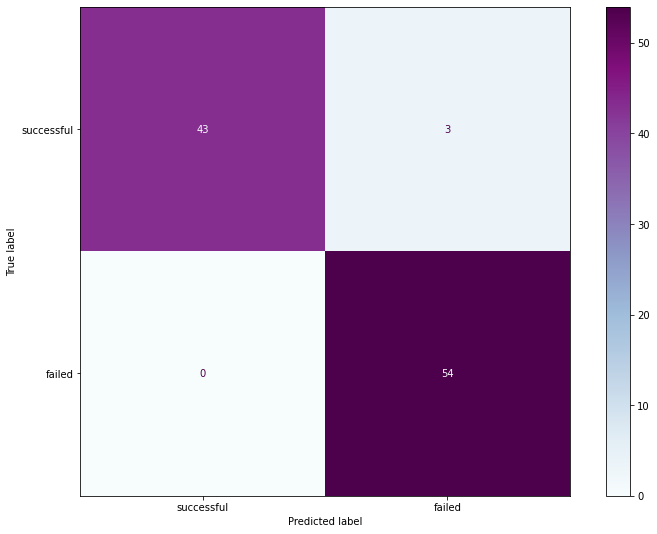

In [19]:
print(expected_classes, predicted_classes)
print(classification_report(expected_classes, predicted_classes, target_names=['successful', 'failed']))

disp = ConfusionMatrixDisplay.from_predictions(expected_classes, predicted_classes, display_labels=['successful', 'failed'], cmap=plt.cm.BuPu)
plt.show()

## KNN - Centroidy

In [20]:
class KnnCentroids(KnnBase):
    def __init__(self, df):
        super().__init__(df)
        self.clusters = []
        self.create_startups_objects(df, True)
        self.generate_random_clusters()

    def train(self):
        points_changed = self.match_point_to_clusters()
        counter = 0
        while points_changed and counter < 1000000:
            counter += 1
            self.reposition_clusters()
            points_changed = self.match_point_to_clusters()

        for cluster in self.clusters:
            print(cluster.to_string())

    def generate_random_clusters(self):
        clusters =  []
        for i in [0, 1]:
            pledged = rand.uniform(self.df['pledged'].min(), self.df['pledged'].max())
            state = i
            backers = rand.uniform(self.df['backers'].min(), self.df['backers'].max())
            pledged_ratio = rand.uniform(self.df['launched'].min(), self.df['launched'].max())
            clusters.append(
                Startup(pd.Series({
                    'pledged': pledged,
                    'backers': backers,
                    'pledged_ratio': pledged_ratio,
                    'state': state,
                }))
            )

        self.clusters = clusters

    def reposition_clusters(self):
        for cluster in self.clusters:
            pledged_sum = 0
            backers_sum = 0
            pledged_ratio_sum = 0
            count = 0

            for item in self.items_objects:
                if item.state == cluster.state:
                    pledged_sum += item.pledged
                    backers_sum += item.backers
                    pledged_ratio_sum += item.pledged_ratio
                    count += 1

            if count > 0:
                cluster.pledged = pledged_sum / count
                cluster.backers = backers_sum / count
                cluster.pledged_ratio = pledged_ratio_sum / count

    def match_point_to_clusters(self):
        changed = 0
        for item in self.items_objects:
            current_state = item.state
            best_distance = None

            for cluster in self.clusters:
                if best_distance is None:
                    best_distance = item.get_distance_from(cluster)
                    new_state = cluster.state
                else:
                    new_distance = item.get_distance_from(cluster)
                    if new_distance < best_distance:
                        best_distance = new_distance
                        new_state = cluster.state

            if current_state != new_state:
                item.state = new_state
                changed += 1
        return changed

    def classify(self, item, print_result=True):
        distance = None
        item_class = None
        for cluster in self.clusters:
            new_distance = item.get_distance_from(cluster)
            new_item_class = cluster.state

            if distance is None:
                distance = new_distance
            if item_class is None:
                item_class = new_item_class
            if distance is not None and distance < new_distance:
                item_class = new_item_class
        if print_result:
            print(f'Element sklasyfikowany jako {item_class}')

        return item_class

### Metryki klasyfikacji KNN dla centroidów

In [21]:
knn_centroids = KnnCentroids(df_train)
knn_centroids.train()

test_data_size = df_test['state'].count()
classified_correctly = 0

expected_classes = []
predicted_classes = []

for i in range(0, test_data_size):
    new_object = Startup(df_test.iloc[i])
    expected_outcome = new_object.state
    predicted_outcome = knn_centroids.classify(new_object, False)

    expected_classes.append(expected_outcome)
    predicted_classes.append(predicted_outcome)

    if predicted_outcome == expected_outcome:
        classified_correctly += 1

print(f'\npledged mean: {df["pledged"].mean()}, backers mean: {df["backers"].mean()}, pledged_ratio mean: {df["pledged_ratio"].mean()}')

pledged: 0.23869677773129178, backers: 0.32225282401309224, pledged_ratio: 0.01067898190420102, state: 0.0
pledged: 0.006184580571301632, backers: 0.00781732557486603, pledged_ratio: 0.00221869556718473, state: 1.0

pledged mean: 0.009978849424528558, backers mean: 0.012991737516465093, pledged_ratio mean: 0.0033128326098580884


              precision    recall  f1-score   support

  successful       0.46      1.00      0.63        46
      failed       1.00      0.02      0.04        54

    accuracy                           0.47       100
   macro avg       0.73      0.51      0.34       100
weighted avg       0.75      0.47      0.31       100



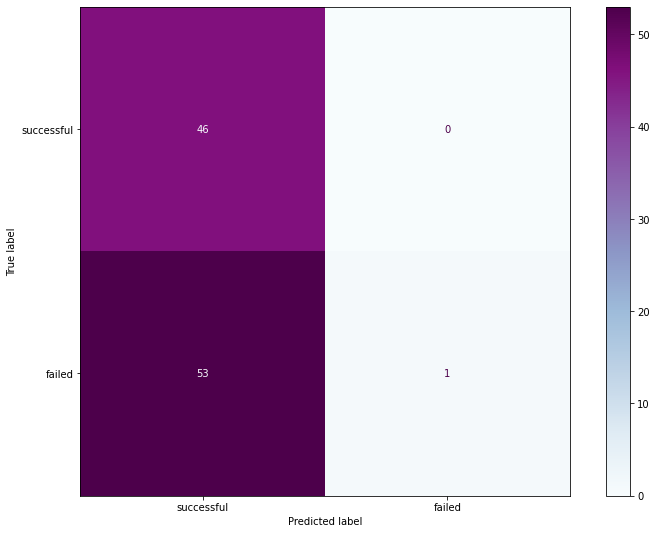

In [22]:

print(classification_report(expected_classes, predicted_classes, target_names=['successful', 'failed']))

disp = ConfusionMatrixDisplay.from_predictions(expected_classes, predicted_classes, display_labels=['successful', 'failed'], cmap=plt.cm.BuPu)
plt.show()

In [23]:
def gauss(x, avg, std):
    return np.exp(-(x - avg)**2 / (2 * std**2))

<AxesSubplot:>

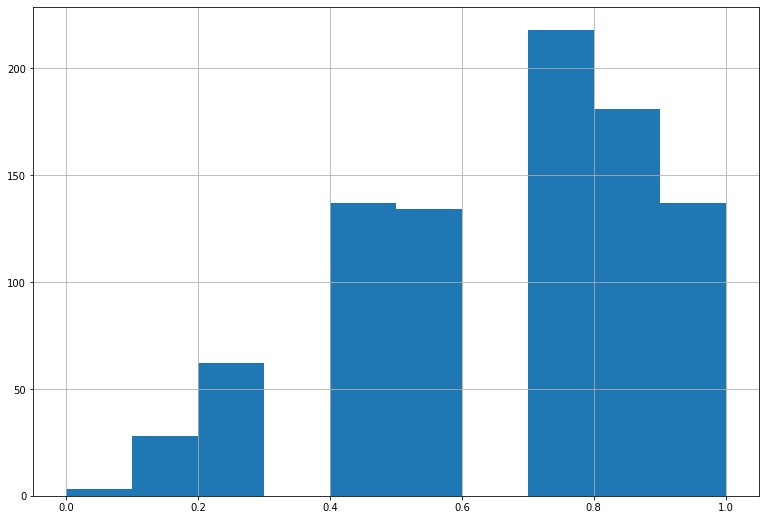

In [24]:
df_train['launched'].hist()

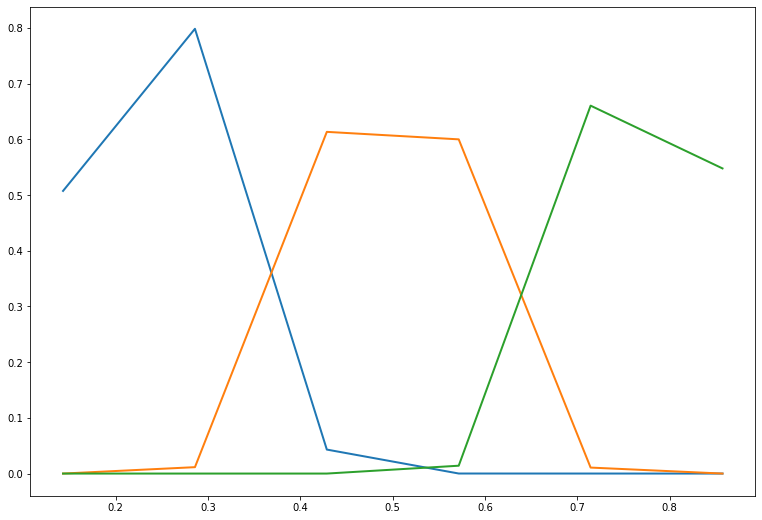

In [25]:
max_range = sorted(df_train.query('0.0 < launched < 1.0')['launched'])
max_1 = sorted(df_train.query('0.0 <= launched < 0.3')['launched'])
max_2 = sorted(df_train.query('0.3 <= launched < 0.7')['launched'])
max_3 = sorted(df_train.query('0.7 <= launched < 1.0')['launched'])

plt.plot(max_range, gauss(max_range, np.mean(max_1), np.std(max_1)), linewidth=2)
plt.plot(max_range, gauss(max_range, np.mean(max_2), np.std(max_2)), linewidth=2)
plt.plot(max_range, gauss(max_range, np.mean(max_3), np.std(max_3)), linewidth=2)

<AxesSubplot:>

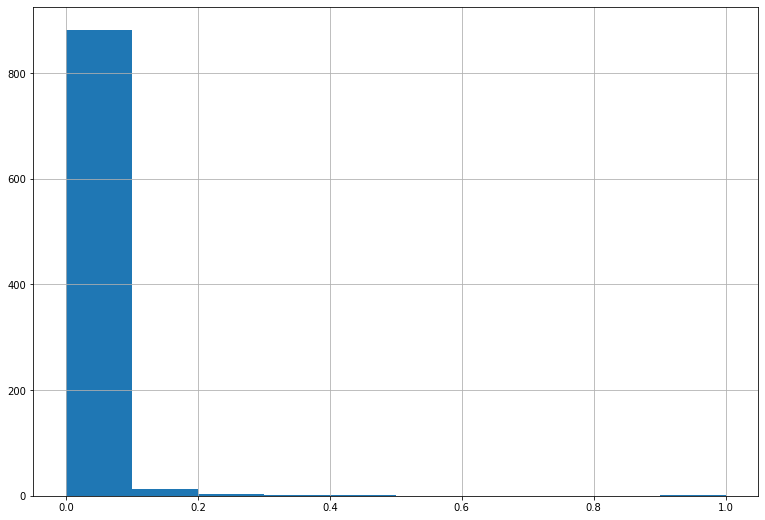

In [26]:
df_train['pledged'].hist()

C:\Users\Hubert\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Hubert\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Hubert\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Hubert\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Hubert\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret =

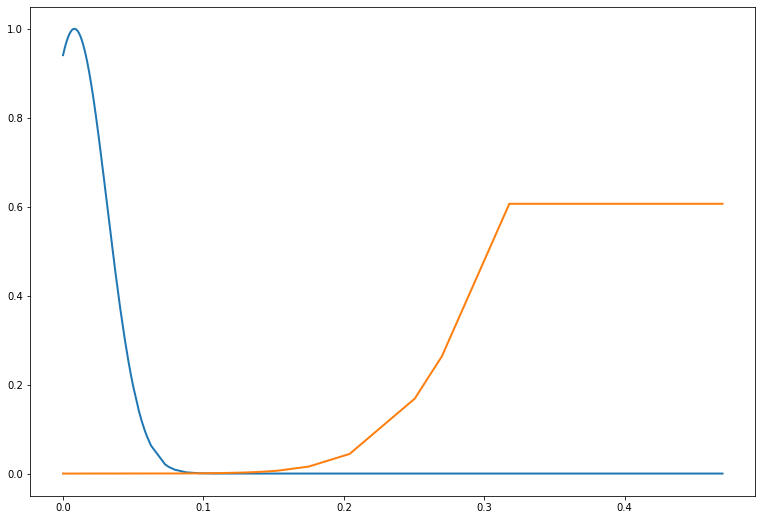

In [27]:
max_range = sorted(df_train.query('0.0 < pledged < 1.0')['pledged'])
max_1 = sorted(df_train.query('0.0 <= pledged < 0.3')['pledged'])
max_2 = sorted(df_train.query('0.3 <= pledged < 0.7')['pledged'])
max_3 = sorted(df_train.query('0.7 <= pledged < 1.0')['pledged'])

plt.plot(max_range, gauss(max_range, np.mean(max_1), np.std(max_1)), linewidth=2)
plt.plot(max_range, gauss(max_range, np.mean(max_2), np.std(max_2)), linewidth=2)
plt.plot(max_range, gauss(max_range, np.mean(max_3), np.std(max_3)), linewidth=2)

<AxesSubplot:>

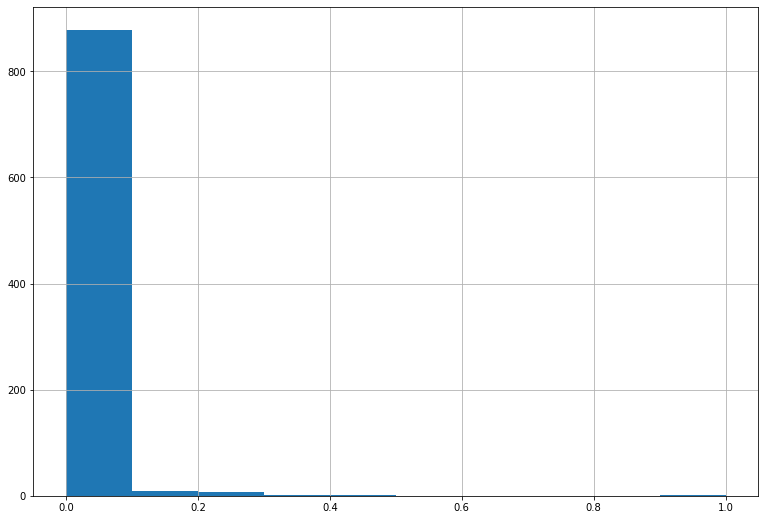

In [28]:
df_train['backers'].hist()

C:\Users\Hubert\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Hubert\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Hubert\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Hubert\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Hubert\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret =

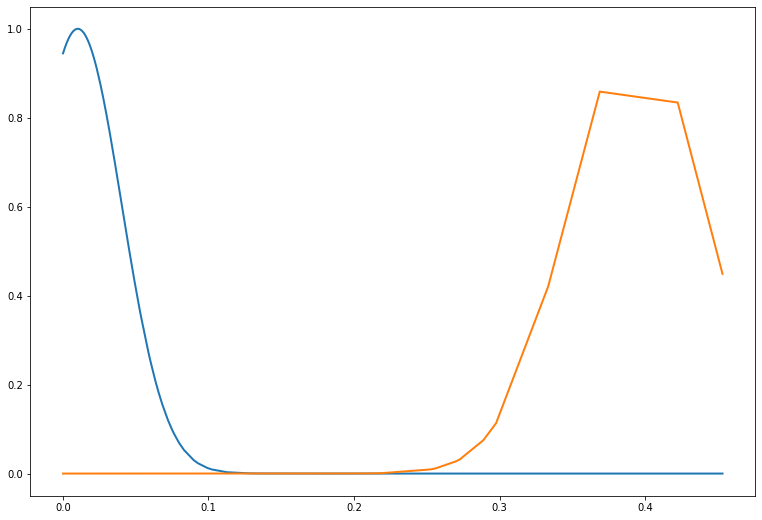

In [29]:
max_range = sorted(df_train.query('0.0 < backers < 1.0')['backers'])
max_1 = sorted(df_train.query('0.0 <= backers < 0.3')['backers'])
max_2 = sorted(df_train.query('0.3 <= backers < 0.7')['backers'])
max_3 = sorted(df_train.query('0.7 <= backers < 1.0')['backers'])

plt.plot(max_range, gauss(max_range, np.mean(max_1), np.std(max_1)), linewidth=2)
plt.plot(max_range, gauss(max_range, np.mean(max_2), np.std(max_2)), linewidth=2)
plt.plot(max_range, gauss(max_range, np.mean(max_3), np.std(max_3)), linewidth=2)

### Gauss dla kolumn

## Reguły rozmyte